In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc
import psutil
from ase.io import read
import ase
import os
from heapq import nsmallest
%matplotlib inline
print(os.listdir("../../inputs"))
print('ase version', ase.__version__)

def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))
show_ram_usage()

['test.csv', 'train.csv', 'potential_energy.csv', 'magnetic_shielding_tensors.csv', 'scalar_coupling_contributions.csv', 'sample_submission.csv', 'mulliken_charges.csv', 'structures.csv', 'dipole_moments.csv', 'structures']
ase version 3.17.0
RAM usage: 0.12204742431640625 GB


In [2]:
%%time
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
# Load the data
train = pd.read_csv('../../inputs/train.csv', index_col='id', dtype=train_dtypes)
# ---------------------------------------------------------------
show_ram_usage()

# Let's work with a single dataframe 1JHN to begin with

def build_type_dataframe(base, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    return base

df_1JHN = build_type_dataframe(train, '1JHN')
print(df_1JHN.shape)
print(display(df_1JHN.head()))

del train
gc.collect()
# ---------------------------------------------------------------
# Extract mol_name, [atom_index0, atom_index1] as a list
def extract_base(base):
    mol_name = base['molecule_name'].to_numpy()
    atom_index0 = base['atom_index_0'].to_numpy()
    atom_index1 = base['atom_index_1'].to_numpy()
    return mol_name, atom_index0, atom_index1

mol_train, atom_index0_train, atom_index1_train = extract_base(df_1JHN)

#-----------------------------------------------------------------
print(f'There are {df_1JHN.shape[0]} rows in train data.')
print('')
print(f'There are {mol_train.shape[0]} rows in mol_train data.')
print('')
print(f"There are {df_1JHN['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {df_1JHN['atom_index_0'].nunique()} unique atoms.")
print('')
print(f'There are {atom_index0_train.shape[0]} rows in atom_index0_train data.')
print(f'There are {atom_index1_train.shape[0]} rows in atom_index1_train data.')
print('')
# ---------------------------------------------------------------
show_ram_usage()

/home/sher/anaconda2/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


RAM usage: 0.2921638488769531 GB
(43363, 4)


,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant
id,,,,
10,dsgdb9nsd_000002,1,0,32.688900
13,dsgdb9nsd_000002,2,0,32.689098
15,dsgdb9nsd_000002,3,0,32.690498
97,dsgdb9nsd_000012,3,0,55.525200
101,dsgdb9nsd_000012,4,0,54.735901


None
There are 43363 rows in train data.

There are 43363 rows in mol_train data.

There are 28560 distinct molecules in train data.
There are 24 unique atoms.

There are 43363 rows in atom_index0_train data.
There are 43363 rows in atom_index1_train data.

RAM usage: 0.21246337890625 GB
CPU times: user 2.96 s, sys: 247 ms, total: 3.2 s
Wall time: 3.24 s


In [3]:
%%time
# Define functions
# Convert  to mol object using ase
def convert_xyz_to_mol(mol_id):
    mol = read(f'../../inputs/structures/{mol_id}.xyz')
    return mol

# Distance r_b with atom indices
def get_rb(mol, atom_index0, atom_index1):
    r_b = mol.get_distance(atom_index0, atom_index1)
    return r_b

# Acquire r_b, r_i, theta_i for the molecule
def get_ri(mol, rb, atom_index0, atom_index1):
    r_i = []
    angles = []
    for i in range((len(mol))):
        if i == atom_index0:
            #theta_i.append(0)
            r_i.append(0)
            continue
        if i == atom_index1:
            #theta_i.append(0)
            r_i.append(0)
            continue
        angle1 = mol.get_angle(atom_index0, i, atom_index1)
        angle2 = mol.get_angle(atom_index0, atom_index1, i)
        angle3 = mol.get_angle(atom_index1, atom_index0, i)
        angles.append([angle1, angle2, angle3])
        # Get theta from center of bond
        theta = 180 - angle3 - (angle1/2.0)
        # Get distance from center of bond
        r = (rb/2.0)*(np.sin(np.radians(angle3)))/(np.sin(np.radians(angle1/2.0)))
        r_i.append(r) 
    return r_i

def get_theta_i(mol, r_i, atom_index0, atom_index1):
    #angles = []
    theta_i = []
    for i in range((len(mol))):
        if i == atom_index0:
            theta_i.append(0)
            continue
        if i == atom_index1:
            theta_i.append(0)
            continue
        angle1 = mol.get_angle(atom_index0, i, atom_index1)
        #angle2 = mol.get_angle(atom_index0, atom_index1, i)
        angle3 = mol.get_angle(atom_index1, atom_index0, i)
        #angles.append([angle1, angle2, angle3])
        # Get theta from center of bond
        theta = 180 - angle3 - (angle1/2.0)
        theta_i.append(theta) 
    return theta_i

def get_G0(r_b, eta, mu):
    G0_list = []
    for val2 in mu:
        for val1 in eta:
            G0 = np.exp(-val1*(r_b-val2)**2)
            G0_list.append(G0)
    return G0_list

# Define the cut-off function
def fcut(Ri):
    if Ri <= Rc:
        y = 0.5*(np.cos(np.pi*Ri/Rc)+1.0)
    else:
        y = 0
    return y

# Let's Define the radial function G1_atomic

def get_G1(mol, rb, index_0, index_1):
    natom = len(mol)
    atoms = mol.get_atomic_numbers()
    r_i = get_ri(mol, rb, index_0, index_1)
    G1_par = np.zeros(shape=(np1, 5)) # H C N O F 
    for i in range(natom):
        if i == index_0:
            continue
        if i == index_1:
            continue
        for j in range(np1):
            eta_m = p1[j][0]
            mu_m =  p1[j][1]
            G1_temp = np.exp(-eta_m*(r_i[i]-mu_m)**2)*fcut(r_i[i])
            if atoms[i] == 1:
                G1_par[j][0] = G1_par[j][0] + G1_temp
                continue
            if atoms[i] == 6:
                G1_par[j][1] = G1_par[j][1] + G1_temp
                continue
            if atoms[i] == 7:
                G1_par[j][2] = G1_par[j][2] + G1_temp
                continue
            if atoms[i] == 8:
                G1_par[j][3] = G1_par[j][3] + G1_temp
                continue
            if atoms[i] == 9:
                G1_par[j][4] = G1_par[j][4] + G1_temp
    return G1_par

def get_G1_G2(mol, rb, index_0, index_1):
    natom = len(mol)
    atoms = mol.get_atomic_numbers()
    r_i = get_ri(mol, rb, index_0, index_1)    
    theta_i = get_theta_i(mol, r_i, index_0, index_1)
    G1_par = np.zeros(shape=(np2, 5)) # H C N O F 
    G2_pos = np.zeros(shape=(np2, 5)) # H C N O F
    G2_neg = np.zeros(shape=(np2, 5)) # H C N O F
    G2_pos1 = np.zeros(shape=(np2, 5)) # H C N O F
    G2_neg1 = np.zeros(shape=(np2, 5)) # H C N O F
    for i in range(natom):
        if i == index_0:
            continue
        if i == index_1:
            continue
        for j in range(np2):
            eta_m = p2[j][0]
            mu_m =  p2[j][1]
            G1_temp = np.exp(-eta_m*(r_i[i]-mu_m)**2)*fcut(r_i[i])
            G2pos_temp = ((1 + abs(np.cos(np.radians(theta_i[i]))))**1.0)*G1_temp
            G2neg_temp = ((1 + abs(np.cos(np.radians(theta_i[i]))))**4.0)*G1_temp
            if atoms[i] == 1:
                G1_par[j][0] = G1_par[j][0] + G1_temp
                G2_pos[j][0] = G2_pos[j][0] + G2pos_temp
                G2_neg[j][0] = G2_neg[j][0] + G2neg_temp
                continue
            if atoms[i] == 6:
                G1_par[j][1] = G1_par[j][1] + G1_temp
                G2_pos[j][1] = G2_pos[j][1] + G2pos_temp
                G2_neg[j][1] = G2_neg[j][1] + G2neg_temp
                continue
            if atoms[i] == 7:
                G1_par[j][2] = G1_par[j][2] + G1_temp
                G2_pos[j][2] = G2_pos[j][2] + G2pos_temp
                G2_neg[j][2] = G2_neg[j][2] + G2neg_temp
                continue
            if atoms[i] == 8:
                G1_par[j][3] = G1_par[j][3] + G1_temp
                G2_pos[j][3] = G2_pos[j][3] + G2pos_temp
                G2_neg[j][3] = G2_neg[j][3] + G2neg_temp
                continue
            if atoms[i] == 9:
                G1_par[j][4] = G1_par[j][4] + G1_temp
                G2_pos[j][4] = G2_pos[j][4] + G2pos_temp
                G2_neg[j][4] = G2_neg[j][4] + G2neg_temp
    return G2_pos, G2_neg, r_i

                

### Define Globals
Rc = 6.0

# Define eta, mu
#eta0 = [10, 1000, 2500, 5000, 7500, 10000, 50000, 100000] 
#mu0 = [1.00]
#eta0 = [10, 50, 100, 250, 500] # 5 values defined
#mu0 = [0.97]
eta0 = [1000] # 5 values defined
mu0 = [1.0,   1.04,  1.08, 1.12, 1.15]
np0 = len(eta0) * len(mu0)


#eta1 = [0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 40.0] 
#mu1 = [0.0, 1.0]
eta1 = [6.3775510]
mu1 = np.arange(0.0, 5.6, 0.25)
np1 = len(eta1) * len(mu1)
p1 =  [[i,j] for i in eta1 for j in mu1]

zeta = 1.0

eta2 = [0.1, 0.5]
mu2 = [0.0]
np2 = len(eta2) * len(mu2)
p2 =  [[i,j] for i in eta2 for j in mu2]

    
    
rb_train = []
ri_list = []
G0_train_list = []
G1_train_list = []
G2pos_train_list = []
G2neg_train_list = []
for i, m in enumerate(mol_train):
    mol = convert_xyz_to_mol(m)
    rb = get_rb(mol, atom_index0_train[i], atom_index1_train[i])
    rb_train.append(rb)
    G0 = get_G0(rb, eta0, mu0)
    G0_train_list.append(G0)
    G1 = get_G1(mol, rb, atom_index0_train[i], atom_index1_train[i])
    G2_pos, G2_neg, ri = get_G1_G2(mol, rb, atom_index0_train[i], atom_index1_train[i])
    G1_train_list.append(G1)
    G2pos_train_list.append(G2_pos)
    G2neg_train_list.append(G2_neg)
    ri_list.append(ri)
    
G0_train = np.array(G0_train_list)
G1_array = np.array(G1_train_list)
G2pos_array = np.array(G2pos_train_list)
G2neg_array = np.array(G2neg_train_list)

G1_train = np.zeros(shape=(len(G1_array), np1*5))
G2pos_train = np.zeros(shape=(len(G2pos_array), np2*5))
G2neg_train = np.zeros(shape=(len(G2neg_array), np2*5))
for i, row1 in enumerate(G1_array):
    G1_train[i] = row1.flatten()
for i, row1 in enumerate(G2pos_array):
    G2pos_train[i] = row1.flatten()
for i, row1 in enumerate(G2neg_array):
    G2neg_train[i] = row1.flatten()
ri_0 = []
ri_1 = []
for i, val in enumerate(ri_list):
    ri_0_temp = nsmallest(4, val)[2]
    ri_1_temp = nsmallest(4, val)[3]
    ri_0.append(ri_0_temp)
    ri_1.append(ri_1_temp)
# ---------------------------------------------------------------
print('Length of rb :')
print(len(rb_train))
print('Length of G0 :')
print(len(G0_train))
print(len(G0_train[0])) # Should be (eta0 x mu0)
print(len(G0_train[1]))
print('Length of G1 :')
print(len(G1_train))
print(len(G1_train[0])) # Should be  (eta1 x mu1)
print(len(G1_train[1]))
print('Length of G2pos :')
print(len(G2pos_train))
print(len(G2pos_train[0])) # Should be  (eta1 x mu1)
print(len(G2pos_train[1]))
print('Length of G2neg :')
print(len(G2neg_train))
print(len(G2neg_train[0])) # Should be  (eta1 x mu1)
print(len(G2neg_train[1]))
# ---------------------------------------------------------------
show_ram_usage()

Length of rb :
43363
Length of G0 :
43363
5
5
Length of G1 :
43363
115
115
Length of G2pos :
43363
10
10
Length of G2neg :
43363
10
10
RAM usage: 0.34069061279296875 GB
CPU times: user 5min, sys: 1.4 s, total: 5min 1s
Wall time: 5min 8s


In [4]:
%%time
# Build complete feature set on original data frame
df_1JHN['rb'] = rb_train
print('rb added!')
print('')
df_1JHN['ri0'] = ri_0
df_1JHN['ri1'] = ri_1
print('Lowest two ri added!')
print('')
for i in range(np0):
    df_1JHN[f'g0_{i}'] = G0_train[:, i]

print('G0 added!')
print('')
for i in range(np1*5):
    df_1JHN[f'g1_{i}'] = G1_train[:, i]
for i in range(np2*5):
    df_1JHN[f'g2p_{i}'] = G2pos_train[:, i]
    df_1JHN[f'g2n_{i}'] = G2neg_train[:, i]
    #df_1JHN = df_1JHN.drop(['atom_index_0', 'atom_index_1', 'molecule_name', 'type'], axis=1)
print('G1, G2 added!')
print('')
print(df_1JHN.shape)
print(display(df_1JHN.head(10)))

del G0_train_list, G1_train_list, G1_train, G1_array, ri_0, ri_1, ri_list
del G2pos_train_list, G2pos_train, G2pos_array, G2neg_train_list, G2neg_train, G2neg_array
# ---------------------------------------------------------------
show_ram_usage()

rb added!

Lowest two ri added!

G0 added!

G1, G2 added!

(43363, 147)


,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,rb,ri0,ri1,g0_0,g0_1,g0_2,...,g2p_5,g2n_5,g2p_6,g2n_6,g2p_7,g2n_7,g2p_8,g2n_8,g2p_9,g2n_9
id,,,,,,,,,,,,,,,,,,,,,
10,dsgdb9nsd_000002,1,0,32.688900,1.017190,0.963805,0.963848,0.744162,0.594345,0.019349,...,1.838857,6.984189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
13,dsgdb9nsd_000002,2,0,32.689098,1.017187,0.963808,0.963848,0.744234,0.594268,0.019343,...,1.838852,6.984147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
15,dsgdb9nsd_000002,3,0,32.690498,1.017208,0.963826,0.963829,0.743704,0.594830,0.019393,...,1.838960,6.985778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
97,dsgdb9nsd_000012,3,0,55.525200,1.007511,0.969550,1.326630,0.945144,0.348010,0.005223,...,1.170926,6.090767,0.611999,2.844020,0.000000,0.000000,0.072383,0.145386,0.0,0.0
101,dsgdb9nsd_000012,4,0,54.735901,1.004933,0.972237,1.329141,0.975955,0.292391,0.003571,...,1.119520,5.105815,0.618328,2.997574,0.000000,0.000000,0.097888,0.655807,0.0,0.0
225,dsgdb9nsd_000019,7,2,54.063999,1.004771,0.970822,1.339172,0.977495,0.289070,0.003485,...,1.027102,4.841035,0.654395,3.047061,0.000000,0.000000,0.102611,0.697090,0.0,0.0
229,dsgdb9nsd_000019,8,2,56.186001,1.006952,0.968546,1.334675,0.952823,0.335481,0.004815,...,1.049257,5.227170,0.663478,3.155001,0.000000,0.000000,0.073679,0.134998,0.0,0.0
389,dsgdb9nsd_000032,4,0,37.719002,1.014969,0.964092,1.419738,0.799250,0.534441,0.014567,...,1.141383,4.072528,0.557804,2.245843,0.002114,0.015038,0.000000,0.000000,0.0,0.0
395,dsgdb9nsd_000032,5,0,38.349499,1.015277,0.963764,1.420755,0.791858,0.542673,0.015160,...,1.179465,4.787917,0.543091,1.959846,0.001381,0.001854,0.000000,0.000000,0.0,0.0


None
RAM usage: 0.3287315368652344 GB
CPU times: user 312 ms, sys: 24 ms, total: 336 ms
Wall time: 332 ms


In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_data = df_1JHN.drop(['scalar_coupling_constant', 'atom_index_0', 'atom_index_1', 'molecule_name'], axis=1)
y_data = df_1JHN['scalar_coupling_constant']


y_d = np.array(y_data).reshape(-1, 1)
scaler_x = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()
xscale = scaler_x.fit_transform(X_data)
print('Scaled X')
yscale = scaler_y.fit_transform(y_d)
print('Scaled Data!')
X_train, X_val, y_train, y_val = train_test_split(xscale, yscale, test_size=0.2, random_state=128)
show_ram_usage()

Scaled X
Scaled Data!
RAM usage: 0.4825325012207031 GB


In [6]:
%%time
#Compile model
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from keras_radam import RAdam
import tensorflow as tf
from sklearn.metrics import mean_absolute_error


print('Imported libraries !')




model = keras.models.Sequential()
model.add(keras.layers.Dense(246, input_dim=143))
model.add(keras.layers.Activation('relu'))
#First Hidden Layer
model.add(keras.layers.Dense(64))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
#Second Hidden Layer
model.add(keras.layers.Dense(32))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
#Third Hidden Layer
model.add(keras.layers.Dense(16))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
#Output Layer 
model.add(keras.layers.Dense(1, activation="linear"))
model.add(keras.layers.BatchNormalization())

#Now compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae', 'mse'] )
print('Model Compiled!')
# Fit
history = model.fit(X_train, y_train, epochs=80, batch_size=50,  verbose=1, validation_split=0.2)

print('Model Fit!')
print('Predicting y_validation')
y_pred = model.predict(X_val)
print('Mean Absolute Error:', (mean_absolute_error(y_val, y_pred)))
print('Log of Mean Absolute Error:', np.log(mean_absolute_error(y_val, y_pred)))
print(history.history.keys())

Using TensorFlow backend.


Imported libraries !
Instructions for updating:
Colocations handled automatically by placer.
Model Compiled!
Instructions for updating:
Use tf.cast instead.
Train on 27752 samples, validate on 6938 samples
Epoch 1/80
27752/27752 [==============================] - 3s 99us/step - loss: 0.0872 - mean_absolute_error: 0.2145 - mean_squared_error: 0.0872 - val_loss: 0.0255 - val_mean_absolute_error: 0.1155 - val_mean_squared_error: 0.0255
Epoch 2/80
27752/27752 [==============================] - 2s 77us/step - loss: 0.0411 - mean_absolute_error: 0.1586 - mean_squared_error: 0.0411 - val_loss: 0.0191 - val_mean_absolute_error: 0.0949 - val_mean_squared_error: 0.0191
Epoch 3/80
27752/27752 [==============================] - 2s 79us/step - loss: 0.0398 - mean_absolute_error: 0.1571 - mean_squared_error: 0.0398 - val_loss: 0.0154 - val_mean_absolute_error: 0.0801 - val_mean_squared_error: 0.0154
Epoch 4/80
27752/27752 [==============================] - 2s 73us/step - loss: 0.0322 - mean_absolute

27752/27752 [==============================] - 2s 71us/step - loss: 0.0293 - mean_absolute_error: 0.1355 - mean_squared_error: 0.0293 - val_loss: 0.0055 - val_mean_absolute_error: 0.0558 - val_mean_squared_error: 0.0055
Epoch 34/80
27752/27752 [==============================] - 2s 69us/step - loss: 0.0280 - mean_absolute_error: 0.1309 - mean_squared_error: 0.0280 - val_loss: 0.0086 - val_mean_absolute_error: 0.0694 - val_mean_squared_error: 0.0086
Epoch 35/80
27752/27752 [==============================] - 2s 69us/step - loss: 0.0272 - mean_absolute_error: 0.1311 - mean_squared_error: 0.0272 - val_loss: 0.0055 - val_mean_absolute_error: 0.0554 - val_mean_squared_error: 0.0055
Epoch 36/80
27752/27752 [==============================] - 2s 69us/step - loss: 0.0265 - mean_absolute_error: 0.1294 - mean_squared_error: 0.0265 - val_loss: 0.0061 - val_mean_absolute_error: 0.0590 - val_mean_squared_error: 0.0061
Epoch 37/80
27752/27752 [==============================] - 2s 69us/step - loss: 0.02

27752/27752 [==============================] - 2s 67us/step - loss: 0.0272 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0272 - val_loss: 0.0054 - val_mean_absolute_error: 0.0563 - val_mean_squared_error: 0.0054
Epoch 69/80
27752/27752 [==============================] - 2s 68us/step - loss: 0.0252 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0252 - val_loss: 0.0075 - val_mean_absolute_error: 0.0682 - val_mean_squared_error: 0.0075
Epoch 70/80
27752/27752 [==============================] - 2s 67us/step - loss: 0.0253 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0253 - val_loss: 0.0051 - val_mean_absolute_error: 0.0546 - val_mean_squared_error: 0.0051
Epoch 71/80
27752/27752 [==============================] - 2s 68us/step - loss: 0.0264 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0264 - val_loss: 0.0051 - val_mean_absolute_error: 0.0537 - val_mean_squared_error: 0.0051
Epoch 72/80
27752/27752 [==============================] - 2s 68us/step - loss: 0.02

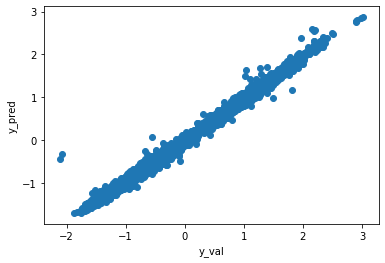

CPU times: user 306 ms, sys: 0 ns, total: 306 ms
Wall time: 303 ms


In [7]:
%%time
import matplotlib.pyplot as plt

# Create data
x, y = y_val, y_pred
# Plot
plt.scatter(x, y)
plt.title('')
plt.xlabel('y_val')
plt.ylabel('y_pred')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'loss', 'mean_absolute_error', 'mean_squared_error'])


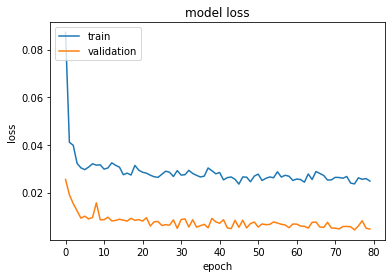

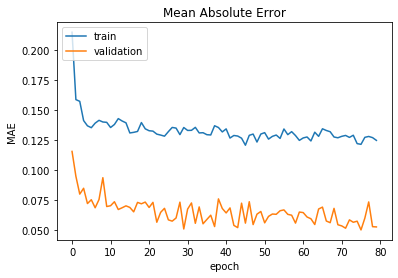

In [8]:
print(history.history.keys())
#['val_loss', 'val_mean_absolute_error', 'val_mean_squared_error',
# 'loss', 'mean_absolute_error', 'mean_squared_error']


# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# MAE
plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()